### Battery Classification: PCA & Clustering For Chemistry Classification

In [1]:
#Import packages
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import requests
from IPython.display import Image, display

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
print('Packages Loaded....')

Packages Loaded....


In this notebook, we'll examine if Principal Component Analysis (PCA) could be used in conjustion with visual clustering to distinguish the chemistry specific cells based on differences in their input features. PCA works by reducing the dimensionality by identifying a new set of components in a lower dimension plane that maximizes the variance captured. By applying PCA we may be able to visually segregate chemistry classes into discrete, separated clusters. Let's get started....

We'll start by taking the characteristic features (voltage, C-rate, and temperature), and extract their aggregated characteristics (mean, standard deviation, max, and min). Each chemistry has a unique voltage curvature, which changes slightly as a functon of C-rate and temperature. An example of the chemistry-specific voltage curves is shown below. Based on these fundamental characteristics, classification might be achievable considering differences in voltage characteristics across the C-rate and temperature feature set. 

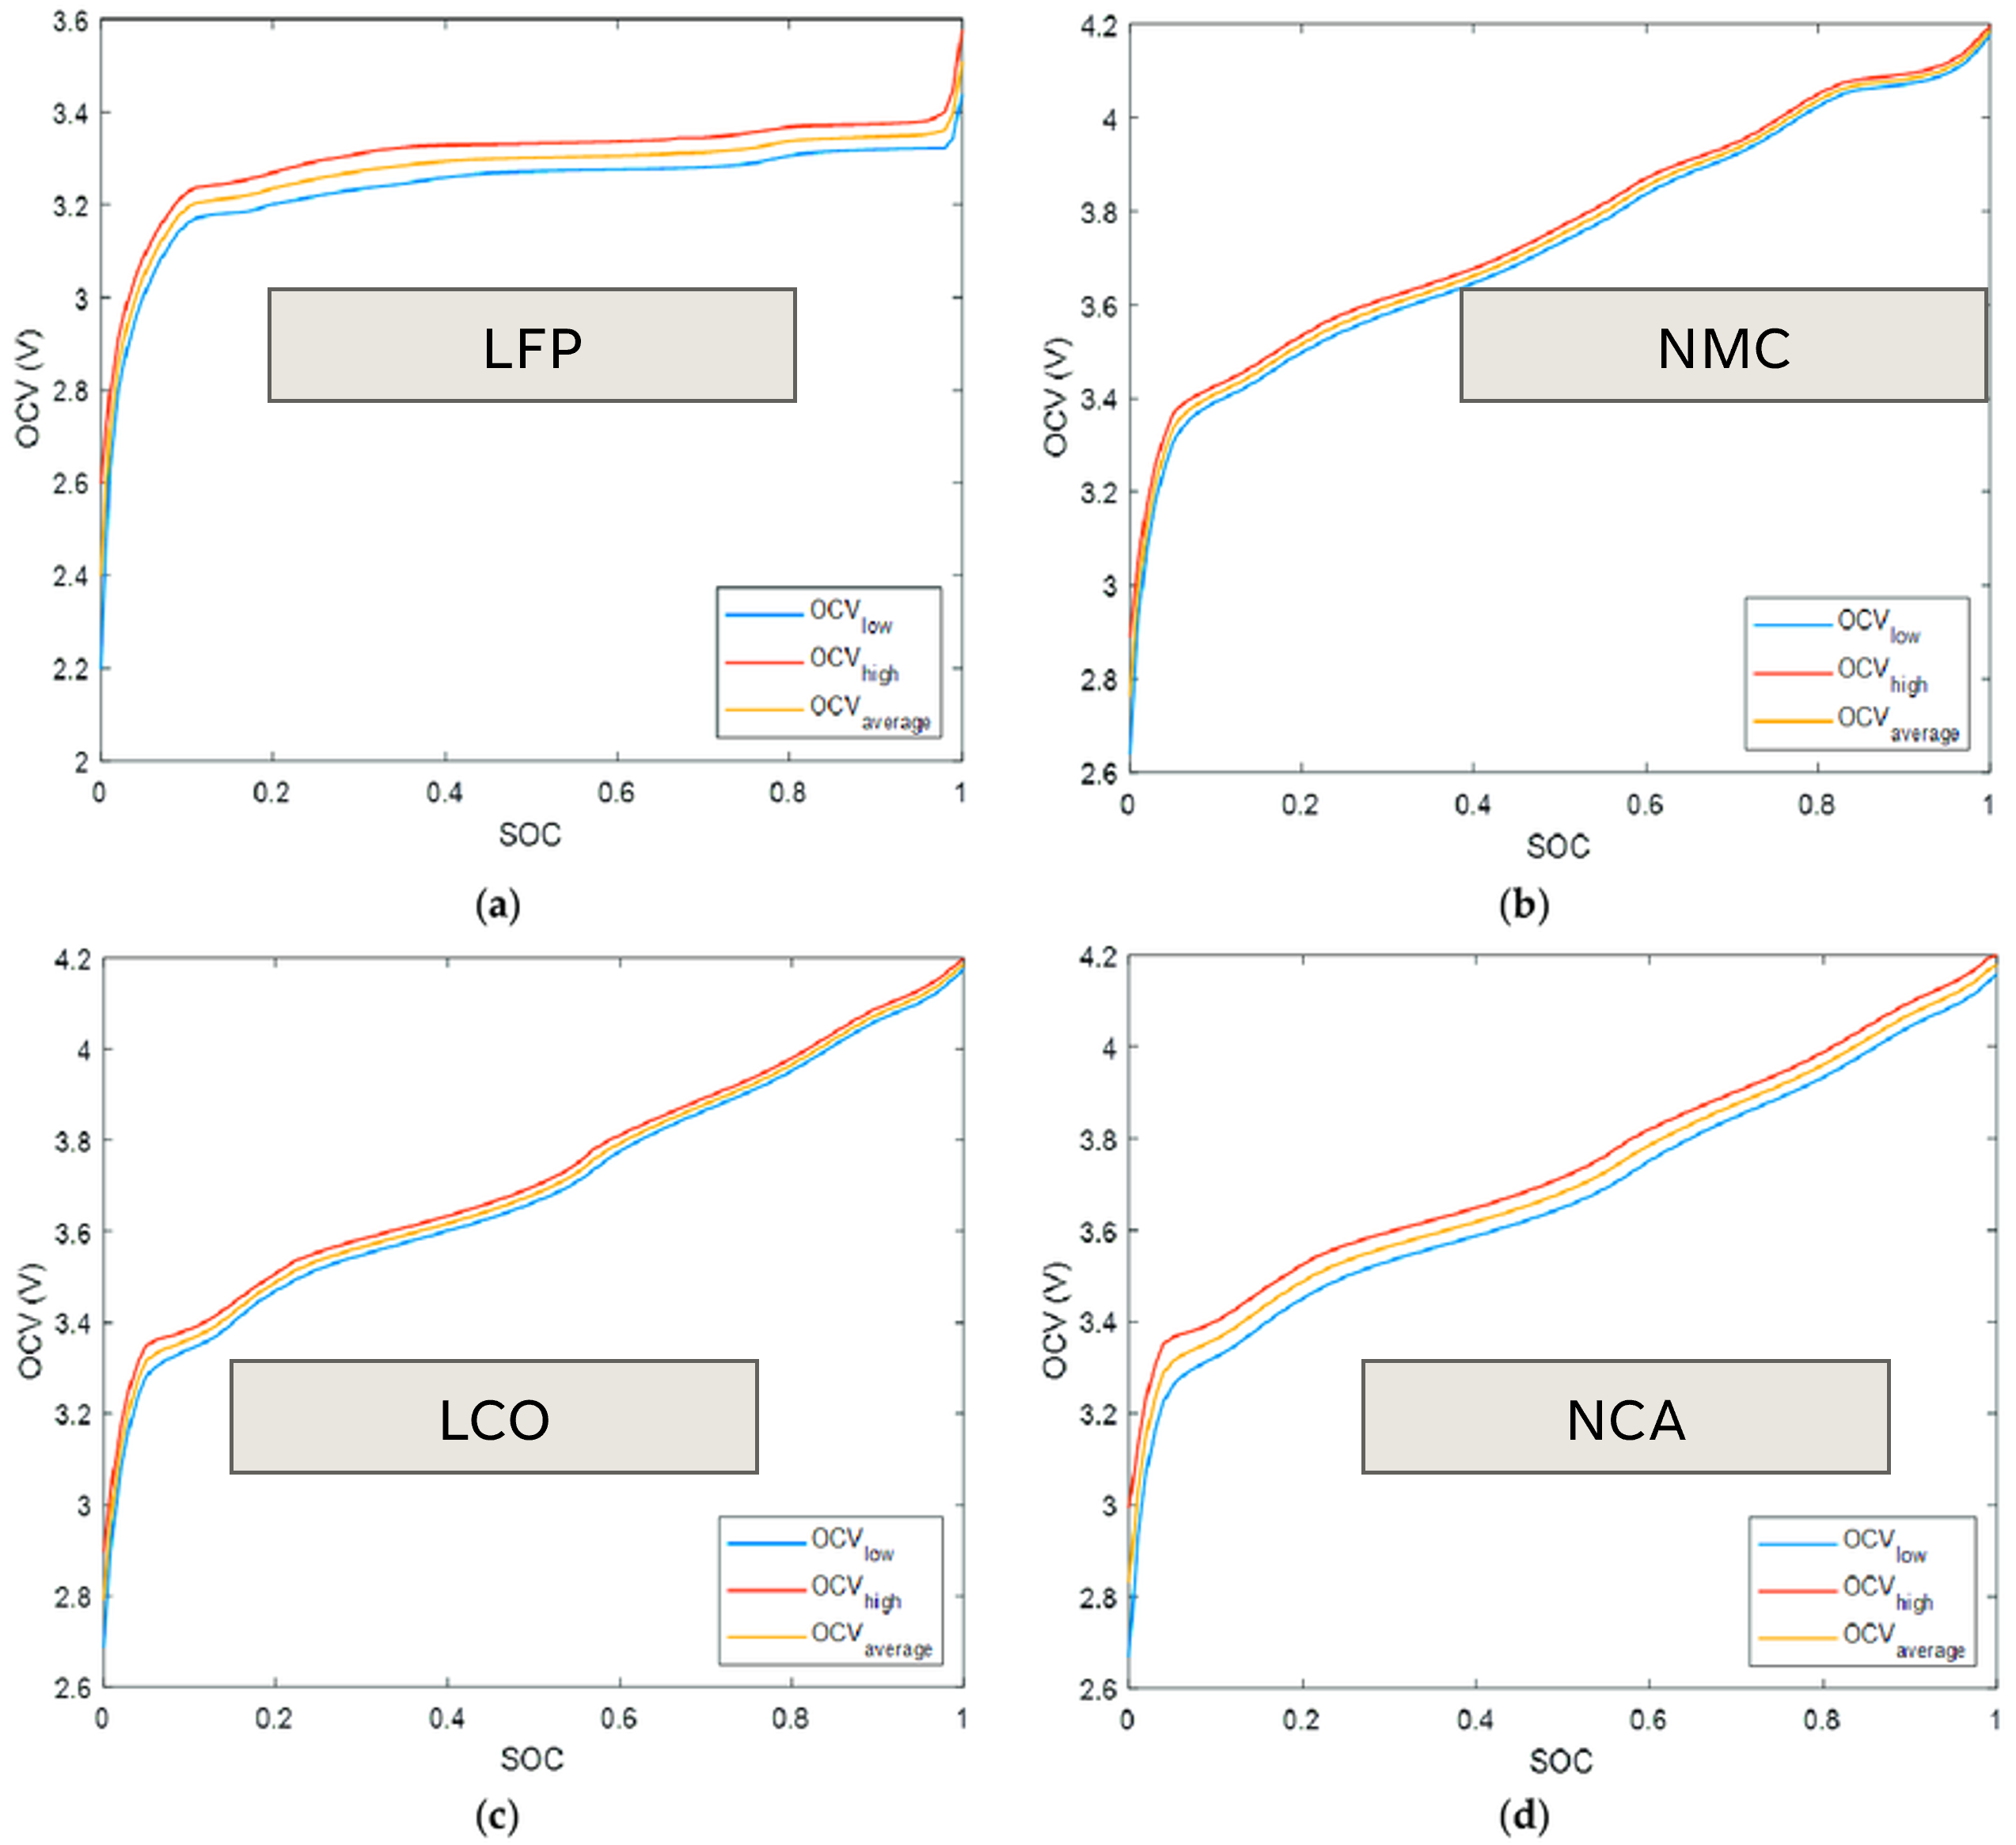

Attribution: Tran et al, Comparative Study of Equivalent Circuit Models Performance in Four Common Lithium-Ion Batteries: LFP, NMC, LMO, NCA, Batteries 2021
DOI: https://doi.org/10.3390/batteries7030051


In [2]:
url = 'https://drive.google.com/uc?export=view&id=1Z3cBoZmfh-rB_sRv6p10rhPI8V3PY9NY'
image_data = requests.get(url).content
display(Image(data=image_data, width=650, height=650))
print("Attribution: Tran et al, Comparative Study of Equivalent Circuit Models Performance in Four Common Lithium-Ion Batteries: LFP, NMC, LMO, NCA, Batteries 2021")
print("DOI: https://doi.org/10.3390/batteries7030051")

#### Let's start by constructing the aggregated feature-set: 

In [3]:

def summarize_features(input_df, chemistry, chemistry_filepath, desired_features):
    """This function takes the input_features and finds the mean, min, max and standard deviation for each of them,
    returning a dataframe of the aggregated features for each unique battery, along with its chemistry. 
    Inputs: input_df (pandas dataframe), chemistry (str), chemistry_filepath (str), and desired_features (list)
    Outputs: agg_data (pandas dataframe)"""

    tdf = input_df[desired_features]

    agg_data = {}
    for col in tdf.columns:
        agg_data[f"{col}_mean"] = tdf[col].mean()
        agg_data[f"{col}_std"] = tdf[col].std()
        agg_data[f"{col}_min"] = tdf[col].min()
        agg_data[f"{col}_max"] = tdf[col].max()
    
    # Add metadata
    agg_data["chemistry"] = chemistry
    agg_data["file"] = chemistry_filepath
    return agg_data


def agg_chem_features(input_dir): 
    """This function walks through an input directory, finds each chemistry folder and the battery id 
    folders embedded in each of them. For each battery ID, it reads the file to a dataframe and 
    aggregates the desired features using summarize features.  
    Inputs: input_dir (str)
    Outputs: result_df (pandas dataframe)"""

    chemistries = os.listdir(input_dir)
    desired_features = ["cycle_index","normalized_time","voltage_v", "c_rate","temperature_k"]
    all_data = []
    for chemistry in chemistries:
        chemistry_path = os.path.join(input_dir, chemistry)
        for chemistry_folder in os.listdir(chemistry_path):
            chemistry_filepath = os.path.join(chemistry_path, chemistry_folder)
            chemistry_filepath_dir = os.listdir(chemistry_filepath)
            desired_files = [temp_file for temp_file in chemistry_filepath_dir if "error_log" not in temp_file]
            
            charge_filepath = None
            discharge_filepath = None

            for file in desired_files: 
                if "discharge" in file:
                    discharge_filepath = os.path.join(chemistry_filepath, file)
                elif "charge" in file: 
                    charge_filepath = os.path.join(chemistry_filepath, file)
                    
            # Only proceed if both files were found
            if not (charge_filepath and discharge_filepath):
                continue
                
            # Read the file for charge and discharge 
            charge_df = pd.read_csv(charge_filepath)
            discharge_df = pd.read_csv(discharge_filepath)
            if len(charge_df) > 0 and len(discharge_df)>0: 
                if charge_df.c_rate.iloc[0] == "variable" or discharge_df.c_rate.iloc[0] == "variable": 
                    continue 
                else: 
                    charge_data = summarize_features(charge_df, chemistry, charge_filepath, desired_features)
                    discharge_data = summarize_features(discharge_df, chemistry, discharge_filepath, desired_features)

                    # Convert dicts to DataFrames for concat
                    charge_data = pd.DataFrame([charge_data])
                    discharge_data = pd.DataFrame([discharge_data])

                    # Add column naming to distinguish between charge and discharge
                    charge_data.columns = ['charge_' + col if col not in ['chemistry', 'file'] else col for col in charge_data.columns]
                    discharge_data.columns = ['discharge_' + col if col not in ['chemistry', 'file'] else col for col in discharge_data.columns]

                    combined_df = pd.concat([charge_data, discharge_data], axis=1)  # ✅ axis=1 to combine horizontally
                    all_data.append(combined_df)
    
    # Combine all per-file aggregates
    result_df = pd.concat(all_data, ignore_index=True)  # ✅ concat instead of DataFrame(list_of_dfs)
    return result_df


input_dir = r'..\assets\processed'
result_df = agg_chem_features(input_dir)

#show initial dataframe of agg features
result_df.sample(3)

,charge_cycle_index_mean,charge_cycle_index_std,charge_cycle_index_min,charge_cycle_index_max,charge_normalized_time_mean,charge_normalized_time_std,charge_normalized_time_min,charge_normalized_time_max,charge_voltage_v_mean,charge_voltage_v_std,...,discharge_c_rate_mean,discharge_c_rate_std,discharge_c_rate_min,discharge_c_rate_max,discharge_temperature_k_mean,discharge_temperature_k_std,discharge_temperature_k_min,discharge_temperature_k_max,chemistry,file
168,50.5,28.867513,1,100,0.5,0.291591,0.0,1.0,3.518629,0.085713,...,1.0,0.0,1.0,1.0,298.0,0.0,298.0,298.0,LFP,..\assets\processed\LFP\MIT_20180412_cell_37_p...
301,50.5,28.867513,1,100,0.5,0.291591,0.0,1.0,4.169751,0.072157,...,1.2,0.0,1.2,1.2,303.0,0.0,303.0,303.0,NMC,..\assets\processed\NMC\G33C4\G33C4_discharge_...
228,50.5,28.867513,1,100,0.5,0.291591,0.0,1.0,3.908464,0.234893,...,0.5,0.0,0.5,0.5,303.0,0.0,303.0,303.0,NMC,..\assets\processed\NMC\G16C3\G16C3_discharge_...


A brief note on the aggregated features. While we don't need the min, max, and standard deviation for most of the features, we charge and discharge features are intentionally separated because of hysteresis phenomena observed in battery cycling where the voltage curve is dependent on the orientation as shown below: 

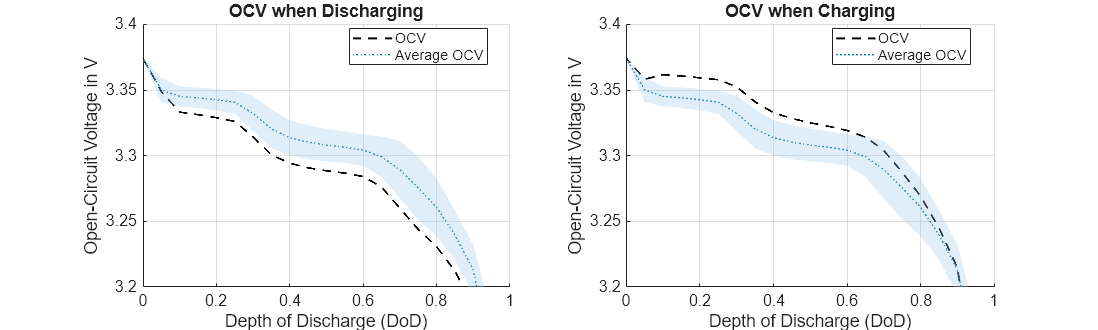

Attribution: Van der Ven et al, “Hysteresis in Electrochemical Systems”, Battery Energy 2022
DOI: https://doi.org/10.1002/bte2.20210017


In [4]:
url = 'https://drive.google.com/uc?export=view&id=1_gqUI5R5J9jh-CsSo3tpsnqKGhDz1jy6'

# Fetch and display the image
image_data = requests.get(url).content
display(Image(data=image_data, width=800, height=800))

# Attribution info
print("Attribution: Van der Ven et al, “Hysteresis in Electrochemical Systems”, Battery Energy 2022")
print("DOI: https://doi.org/10.1002/bte2.20210017")

In [5]:
#Now let's remove unneeded features: 
strip_cols = ['charge_cycle_index_min', 'charge_cycle_index_max', 'charge_cycle_index_mean', 'charge_cycle_index_std',
              'charge_normalized_time_min', 'charge_normalized_time_max', 'discharge_c_rate_min', 'discharge_c_rate_max',
              'discharge_c_rate_std', 'charge_c_rate_min', 'charge_c_rate_max', 'charge_c_rate_std', 
              'discharge_temperature_k_max', 'discharge_temperature_k_min', 'discharge_temperature_k_std',
              'charge_temperature_k_max', 'charge_temperature_k_min', 'charge_temperature_k_std', 
              'discharge_temperature_k_mean', 'file', 'discharge_cycle_index_mean', 'discharge_cycle_index_max',
              'discharge_cycle_index_min', 'discharge_cycle_index_std',
              'discharge_normalized_time_max', 'discharge_normalized_time_min', 'discharge_normalized_time_std',
              'charge_normalized_time_std', 'charge_normalized_time_mean', 'discharge_normalized_time_mean']

strip_df = result_df.drop(columns=strip_cols, errors='ignore')
strip_df = strip_df.iloc[:, :-1]
strip_df.describe()

,charge_voltage_v_mean,charge_voltage_v_std,charge_voltage_v_min,charge_voltage_v_max,charge_c_rate_mean,charge_temperature_k_mean,discharge_voltage_v_mean,discharge_voltage_v_std,discharge_voltage_v_min,discharge_voltage_v_max,discharge_c_rate_mean
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,3.899511,0.118683,3.328938,3.999174,1.399977,300.521835,3.432435,0.279047,2.860978,3.962457,1.103775
std,0.276600,0.061164,0.349776,0.283815,1.053298,5.525470,0.473689,0.159996,0.709904,0.278645,1.016417
min,3.377945,0.000556,2.031000,3.600100,0.050000,278.150000,2.637594,0.049051,1.966535,3.325765,0.050000
25%,3.540057,0.081608,3.233984,3.600400,1.000000,298.000000,2.829896,0.141093,1.998710,3.590100,0.500000
50%,4.031830,0.091740,3.407541,4.199990,1.000000,303.000000,3.691964,0.234877,2.999700,4.128500,1.000000
75%,4.136526,0.168253,3.492975,4.200979,1.862500,303.000000,3.788750,0.466222,3.578125,4.187750,1.175000
max,4.199498,0.265896,4.199276,4.397600,11.000000,323.000000,3.998701,0.609433,3.910900,4.201000,11.000000


#### Now that we've aggegated our data features, let's apply PCA to see if we can classify the chemistry sets by clustering...

Number of PCA components needed for 95% variance: 5


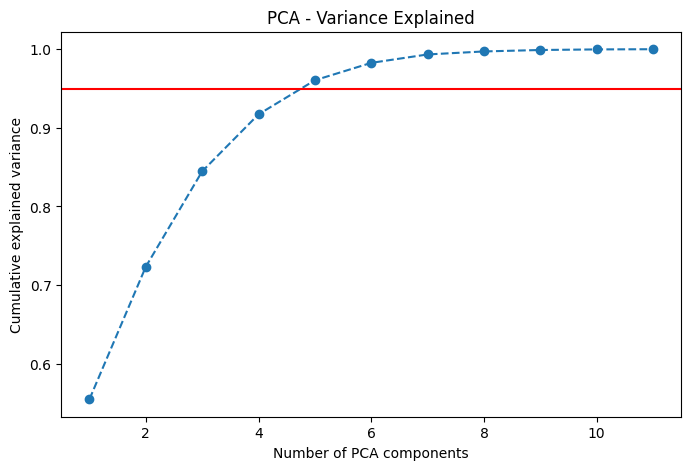

In [6]:
#Now train PCA model:
X = strip_df[[col for col in strip_df.columns if col != 'chemistry']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Find number of components needed for 95% variance
n_components_95 = (cumulative_variance < 0.95).sum() + 1
print(f"Number of PCA components needed for 95% variance: {n_components_95}")

# Plot cumulative variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA - Variance Explained")
plt.show()

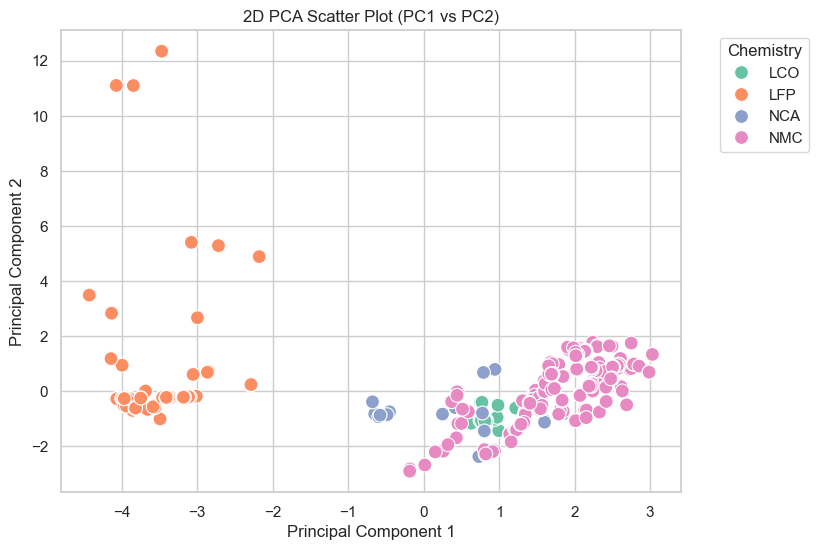

In [7]:
#Let's see how well a 2D projection would separate the groups: 
sns.set(style="whitegrid")

# Prepare numeric features (exclude chemistry) ---
X = strip_df[[col for col in strip_df.columns if col != 'chemistry']]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2 components
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': X_pca_2[:,0],
    'PC2': X_pca_2[:,1],
    'chemistry': strip_df['chemistry'],
    'cluster': clusters
})

# Now Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=plot_df,
    x='PC1',
    y='PC2',
    hue='chemistry',
    palette='Set2',
    s=100
)
plt.title("2D PCA Scatter Plot (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Chemistry', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


At a glance we can see a clear differentiation between the LFP chemistry and non-LFP chemistries when reducing the dataset to just 2 principal components. However, we cannot clearly distinguish NMC, NCA, and LCO chemistries between eachother. Let's now example if adding a 3D principal component would enable proper chemistry classification....  

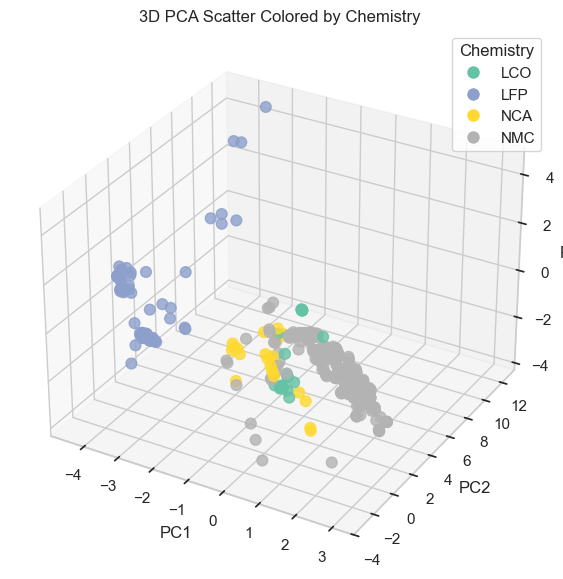

In [8]:
# Prepare numeric features (exclude chemistry)
X = strip_df[[col for col in strip_df.columns if col != 'chemistry']]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 3 components
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)

# KMeans clustering (optional, 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Prepare chemistry codes and labels
chem_codes = strip_df['chemistry'].astype('category').cat.codes
chem_labels = strip_df['chemistry'].astype('category').cat.categories

# 3D scatter plot colored by chemistry
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3[:,0], 
    X_pca_3[:,1], 
    X_pca_3[:,2], 
    c=chem_codes, 
    cmap='Set2', 
    s=60, 
    alpha=0.8
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Scatter Colored by Chemistry')

# Correct legend that matches scatter colors
scatter_colors = scatter.cmap(scatter.norm(range(len(chem_labels))))
handles = [Line2D([0],[0], marker='o', color='w', 
                  markerfacecolor=scatter_colors[i], 
                  markersize=10)
           for i in range(len(chem_labels))]
ax.legend(handles, chem_labels, title='Chemistry')

plt.show()



Unfortunately, using just 3 principal components is unlikely to be suffiicent to distinguish between LCO, NCA, and NMC chemistries when applying a secondary clustering algorithm. We'll show a brief example of how the performance would be using a Kmeans aglorithm

In [9]:
results = pd.DataFrame({
    'chemistry': strip_df['chemistry'],
    'cluster': clusters
})

# Cross-tab (like confusion matrix)
ct = pd.crosstab(results['chemistry'], results['cluster'])
ct

# Map each cluster to the most frequent chemistry inside it
cluster_map = {}
for c in np.unique(clusters):
    mask = clusters == c
    majority_label = results.loc[mask, 'chemistry'].mode()[0]
    cluster_map[c] = majority_label

# Apply the mapping
pred_labels = [cluster_map[c] for c in clusters]

print("Accuracy:", accuracy_score(results['chemistry'], pred_labels))
print("\nClassification report:")
print(classification_report(results['chemistry'], pred_labels, zero_division=0))

print("\nConfusion matrix:")
print(pd.DataFrame(confusion_matrix(results['chemistry'], pred_labels),
                   index=results['chemistry'].unique(),
                   columns=results['chemistry'].unique()))

Accuracy: 0.9008438818565401

Classification report:
              precision    recall  f1-score   support

         LCO       0.00      0.00      0.00        25
         LFP       1.00      1.00      1.00       159
         NCA       0.00      0.00      0.00        22
         NMC       0.85      1.00      0.92       268

    accuracy                           0.90       474
   macro avg       0.46      0.50      0.48       474
weighted avg       0.82      0.90      0.86       474


Confusion matrix:
     LCO  LFP  NCA  NMC
LCO    0    0    0   25
LFP    0  159    0    0
NCA    0    0    0   22
NMC    0    0    0  268


Unfortunately, we can see the model clearly biases to predicting all non-LFP chemistries as NMC. So this method would not be a robust solution option. We will proceed by exploring other options...